Code inspired from :

https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

https://www.kaggle.com/code/moazashraf/lenet-5-classifier-on-chinese-mnist-in-keras

In [8]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

### Load the data

In [2]:
# load the data
IMAGE_DIR="../input/chinese-mnist/data/data"


def load_data():
    file_list = glob.glob(IMAGE_DIR + "/*.jpg")
    x = []
    y = []

    for fname in file_list:
        with Image.open(fname) as img:
            np_img = np.array(img)
        label = int(os.path.split(fname)[-1].split('.')[0].split('_')[3])-1   # totally unreadable, unclean code

        x.append(np_img)
        y.append(label)
    x, y = np.array(x), np.array(y)
    x = np.expand_dims(x, -1)
    x = x / 255.
    return x, y
    
x, y = load_data()

<Axes: ylabel='count'>

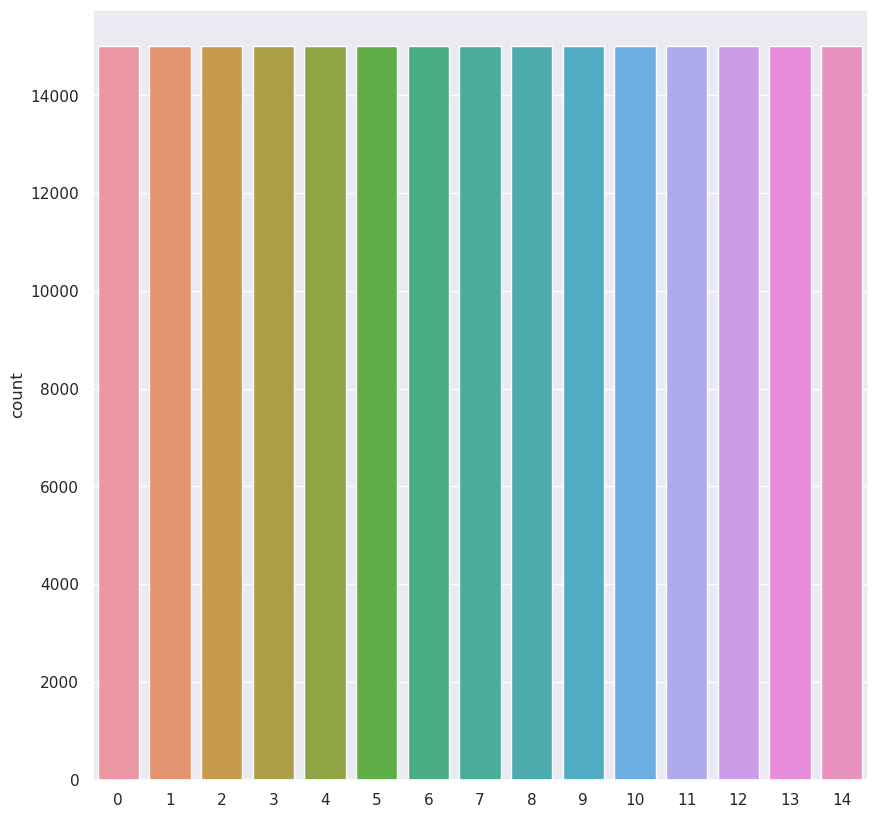

In [24]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(y)

In [ ]:
y = to_categorical(y, num_classes = 15)

In [3]:
x.shape, y.shape

((15000, 64, 64, 1), (15000, 15))

In [4]:
random_seed = 42

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size = 0.1, random_state=random_seed)

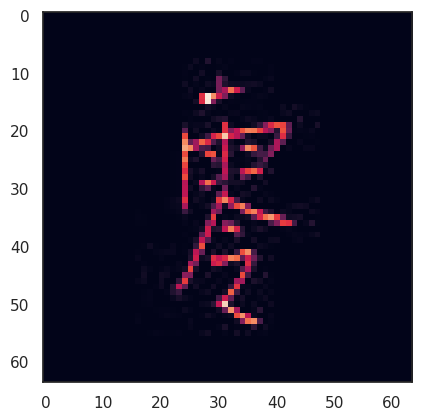

In [6]:
g = plt.imshow(X_train[0][:,:,:])

### Build the model

In [9]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (6,6),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,1)))
model.add(Conv2D(filters = 8, kernel_size = (6,6),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation = "softmax"))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         296       
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 8)         2312      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 4)        

In [11]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
epochs = 30
batch_size = 4

### Data Augmentation

In [15]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

### Train the model

In [16]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30


2023-07-10 14:46:25.809374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3375/3375 - 36s - loss: 2.0397 - accuracy: 0.3633 - val_loss: 15.2352 - val_accuracy: 0.1320 - lr: 0.0010 - 36s/epoch - 11ms/step
Epoch 2/30
3375/3375 - 23s - loss: 0.9897 - accuracy: 0.6576 - val_loss: 0.6891 - val_accuracy: 0.7507 - lr: 0.0010 - 23s/epoch - 7ms/step
Epoch 3/30
3375/3375 - 22s - loss: 0.7308 - accuracy: 0.7465 - val_loss: 1.1902 - val_accuracy: 0.6547 - lr: 0.0010 - 22s/epoch - 6ms/step
Epoch 4/30
3375/3375 - 23s - loss: 0.5962 - accuracy: 0.8020 - val_loss: 0.1790 - val_accuracy: 0.9420 - lr: 0.0010 - 23s/epoch - 7ms/step
Epoch 5/30
3375/3375 - 22s - loss: 0.5256 - accuracy: 0.8227 - val_loss: 0.1275 - val_accuracy: 0.9653 - lr: 0.0010 - 22s/epoch - 7ms/step
Epoch 6/30
3375/3375 - 23s - loss: 0.4707 - accuracy: 0.8445 - val_loss: 0.1351 - val_accuracy: 0.9613 - lr: 0.0010 - 23s/epoch - 7ms/step
Epoch 7/30
3375/3375 - 22s - loss: 0.4394 - accuracy: 0.8565 - val_loss: 0.2333 - val_accuracy: 0.9260 - lr: 0.0010 - 22s/epoch - 7ms/step
Epoch 8/30
3375/3375 - 23s - loss: 0

### Evaluate the model

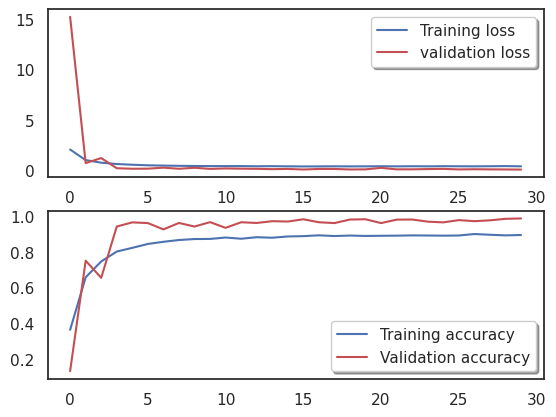

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

47/47 [==============================] - 0s 2ms/step


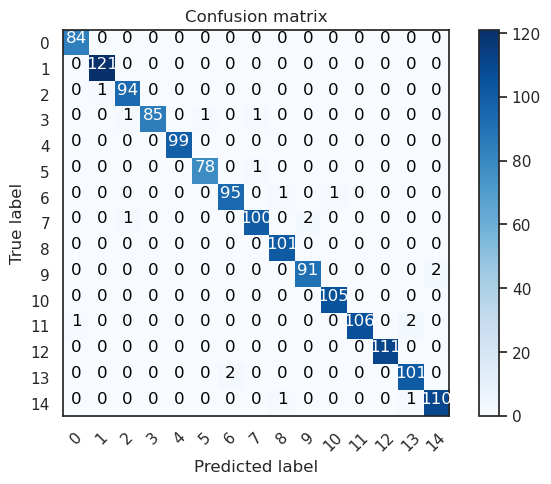

In [17]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(15)) 

In [18]:
code_to_kanji = ['零', '一', '二', '三', '四', '五', '六', '七',
                 '八', '九', '十', '百', '千', '万', '亿']

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20159 (\N{CJK UNIFIED IDEOGRAPH-4EBF}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E

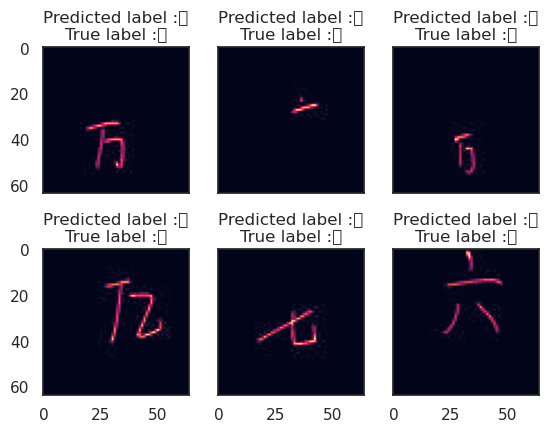

In [19]:
# Display some error results 

plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((64,64)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(code_to_kanji[pred_errors[error]],code_to_kanji[obs_errors[error]]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

五


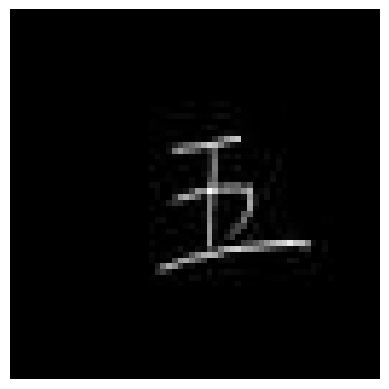

In [20]:
# show an example
example_idx = 10
x_example = X_val[example_idx]
y_example = Y_val[example_idx]
y_pred_ex = model(np.expand_dims(x_example, 0))
y_pred_ex = np.argmax(y_pred_ex)
print(code_to_kanji[y_pred_ex])
plt.imshow(x_example.squeeze(2), cmap='gray')
plt.axis(False)
plt.show()

prediction: 九, truth: 七


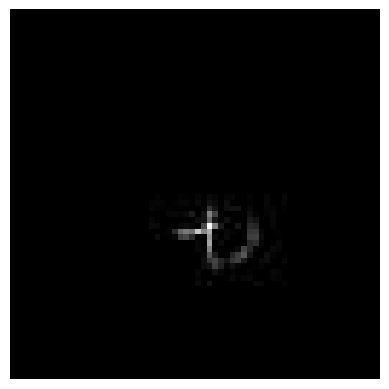

In [21]:
# show a wrong prediction
y_pred_test = model(X_val)
y_pred_test = np.argmax(y_pred_test, -1)
y_val = np.apply_along_axis(np.argmax, axis=1, arr=Y_val)
error_mask = (y_pred_test != y_val)

x_error = X_val[error_mask]
y_pred_error = y_pred_test[error_mask]
y_error = y_val[error_mask]

idx = 0
print(f"prediction: {code_to_kanji[y_pred_error[idx]]}, truth: {code_to_kanji[y_error[idx]]}")
plt.imshow(x_error[idx].squeeze(2), cmap='gray')
plt.axis(False)
plt.show()